In [1]:
import requests        # for making http requests to binance
import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python, i usually need this somewhere 
                       # and so i import by habit nowadays

import matplotlib.pyplot as plt # for charts and such
import matplotlib.ticker as ticker

import itertools
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import pearsonr


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
# from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg

import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

from pylab import rcParams
import pmdarima as pm

# Initialize plotly
init_notebook_mode(connected=True)

from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

import datetime as dt  # for dealing with times
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

In [3]:
df_coinmarket_price_1h = pd.read_csv('datasets/cryptodatadownload/Coinbase_BTCUSD_1h.csv', skiprows=1)
df_coinmarket_price_d = pd.read_csv('datasets/cryptodatadownload/Coinbase_BTCUSD_d.csv', skiprows=1)

In [4]:
#coinmarket
df_coinmarket_price_1h['Date'] = pd.to_datetime(df_coinmarket_price_1h['Date'], format="%Y-%m-%d %I-%p")
df_coinmarket_price_d['Date'] = pd.to_datetime(df_coinmarket_price_d['Date'], format="%Y-%m-%d")

In [5]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_coinmarket_price_d['Date'].max())
print(df_coinmarket_price_d['Date'].min())
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_coinmarket_price_1h['Date'].max())
print(df_coinmarket_price_1h['Date'].min())

------------ df_coinmarket_price_d ------------
2020-04-01 00:00:00
2014-12-01 00:00:00
------------ df_coinmarket_price_1h ------------
2020-04-01 11:00:00
2017-07-01 11:00:00


In [6]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_coinmarket_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_coinmarket_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1937
------------ df_coinmarket_price_1h ------------
24121


In [7]:
def perform_metrics(y_truth, y_forecasted): 
    
    mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
    mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
    mse = round(mean_squared_error(y_truth, y_forecasted), 4)
    rmse = round(mse**(0.5), 4)
    rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
    r2 = round(r2_score(y_truth, y_forecasted), 4)
    corr, _ = pearsonr(y_truth, y_forecasted)
    pearson = round(corr, 4)
    
#     print('mae', mae)
#     print('mape', mape)
#     print('mse', mse)
#     print('rmse', rmse)
#     print('rmspe', rmspe)
#     print('r2', r2)
#     print('pearson', pearson)
    
    return mae, mape, mse, rmse, rmspe, r2, pearson

In [8]:
class ExponentialSmoothing(object):
    
    def __init__(self, df, percentage_train_size, list_alpha, list_beta):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.list_alpha = list_alpha
        self.list_beta = list_beta
            
    def perform(self):
        
        best_params, last_index = self.create_model()
        
        array_pred = np.array([])
        
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred = self.prediction(best_params = best_params, last_index = row[0])
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['Close'].values)

            
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.index[:-last_index], self.df['Close'].values[:-last_index], color="gray")
        ax.plot(self.df.index[-last_index:], self.df['Close'].values[-last_index:], label = 'Close', color="gray")
        ax.plot(self.df.index[-last_index:], self.df.iloc[-last_index:]['Close'].values, color = 'r')
        ax.plot(self.df.index[-last_index:], array_pred.reshape(-1, 1), label="alpha="+str(best_params[0])+", beta="+str(best_params[1]), color = 'r')
        ax.legend()
        plt.show()
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        ax.legend()
        plt.show()
        
        return True
    
    def prediction(self, best_params, last_index):
        
        model = Holt(np.asarray(self.df[:last_index]))
                
        fit_model = model.fit(smoothing_level = best_params[0], smoothing_slope = best_params[1])
        pred = fit_model.forecast( steps = 1)
        
        return pred
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        model = Holt(np.asarray(self.df.iloc[:-last_index]))
        best_aic = np.inf
        best_fit = 0
        
        for alpha in self.list_alpha:
            
            for beta in self.list_beta:
            
                fit_model = model.fit(smoothing_level = alpha, smoothing_slope = beta)
                
                if fit_model.aic < best_aic:
                    best_aic = fit_model.aic
                    best_fit = fit_model
                    best_params = (alpha, beta)
        
        print('AIC', best_aic, 'best_params', best_params)
        
        return best_params, last_index
    
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    



AIC 17288.249021280662 best_params (0.95, 0.0)
last_index 2019-02-28 00:00:00
pred [3794.85092338]
last_index 2019-03-01 00:00:00
pred [3807.81660124]
last_index 2019-03-02 00:00:00
pred [3811.82238777]
last_index 2019-03-03 00:00:00
pred [3790.3736757]
last_index 2019-03-04 00:00:00
pred [3707.34606242]
last_index 2019-03-05 00:00:00
pred [3839.96623261]
last_index 2019-03-06 00:00:00
pred [3853.53149097]
last_index 2019-03-07 00:00:00
pred [3859.10728801]
last_index 2019-03-08 00:00:00
pred [3846.14751858]
last_index 2019-03-09 00:00:00
pred [3915.73556647]
last_index 2019-03-10 00:00:00
pred [3903.91598879]
last_index 2019-03-11 00:00:00
pred [3854.61804383]
last_index 2019-03-12 00:00:00
pred [3861.97833192]
last_index 2019-03-13 00:00:00
pred [3853.7923921]
last_index 2019-03-14 00:00:00
pred [3856.16966942]
last_index 2019-03-15 00:00:00
pred [3902.72630759]
last_index 2019-03-16 00:00:00
pred [3987.92492957]
last_index 2019-03-17 00:00:00
pred [3970.35812953]
last_index 2019-03-

last_index 2019-08-16 00:00:00
pred [10355.71617831]
last_index 2019-08-17 00:00:00
pred [10230.44961096]
last_index 2019-08-18 00:00:00
pred [10317.04779384]
last_index 2019-08-19 00:00:00
pred [10896.01882512]
last_index 2019-08-20 00:00:00
pred [10781.51059825]
last_index 2019-08-21 00:00:00
pred [10168.27168758]
last_index 2019-08-22 00:00:00
pred [10115.88765539]
last_index 2019-08-23 00:00:00
pred [10401.95774359]
last_index 2019-08-24 00:00:00
pred [10166.35976775]
last_index 2019-08-25 00:00:00
pred [10145.7918254]
last_index 2019-08-26 00:00:00
pred [10356.67346316]
last_index 2019-08-27 00:00:00
pred [10186.79498172]
last_index 2019-08-28 00:00:00
pred [9743.36715657]
last_index 2019-08-29 00:00:00
pred [9512.72379592]
last_index 2019-08-30 00:00:00
pred [9584.28862306]
last_index 2019-08-31 00:00:00
pred [9605.39438554]
last_index 2019-09-01 00:00:00
pred [9763.92070014]
last_index 2019-09-02 00:00:00
pred [10356.19805121]
last_index 2019-09-03 00:00:00
pred [10620.81121927]

last_index 2020-01-21 00:00:00
pred [8722.28786489]
last_index 2020-01-22 00:00:00
pred [8667.91559106]
last_index 2020-01-23 00:00:00
pred [8403.65028652]
last_index 2020-01-24 00:00:00
pred [8430.40100442]
last_index 2020-01-25 00:00:00
pred [8336.25512464]
last_index 2020-01-26 00:00:00
pred [8586.46078611]
last_index 2020-01-27 00:00:00
pred [8885.03736132]
last_index 2020-01-28 00:00:00
pred [9373.84937975]
last_index 2020-01-29 00:00:00
pred [9297.47482497]
last_index 2020-01-30 00:00:00
pred [9497.67528304]
last_index 2020-01-31 00:00:00
pred [9347.9026046]
last_index 2020-02-01 00:00:00
pred [9383.36903193]
last_index 2020-02-02 00:00:00
pred [9331.26476106]
last_index 2020-02-03 00:00:00
pred [9287.77697978]
last_index 2020-02-04 00:00:00
pred [9175.18677108]
last_index 2020-02-05 00:00:00
pred [9596.80531311]
last_index 2020-02-06 00:00:00
pred [9759.68831854]
last_index 2020-02-07 00:00:00
pred [9810.65336336]
last_index 2020-02-08 00:00:00
pred [9905.9523081]
last_index 202

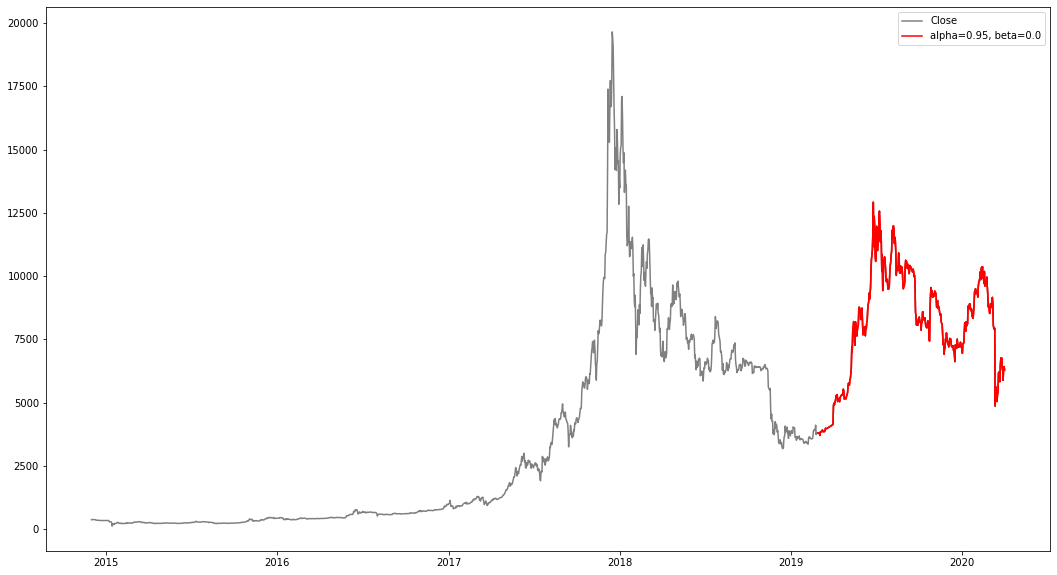

len 387 387
mae 12.4462 mape 0.1511 mse 369.8041 rmse 19.2303 rmspe 0.2581 r2 0.9999 pearson 1.0


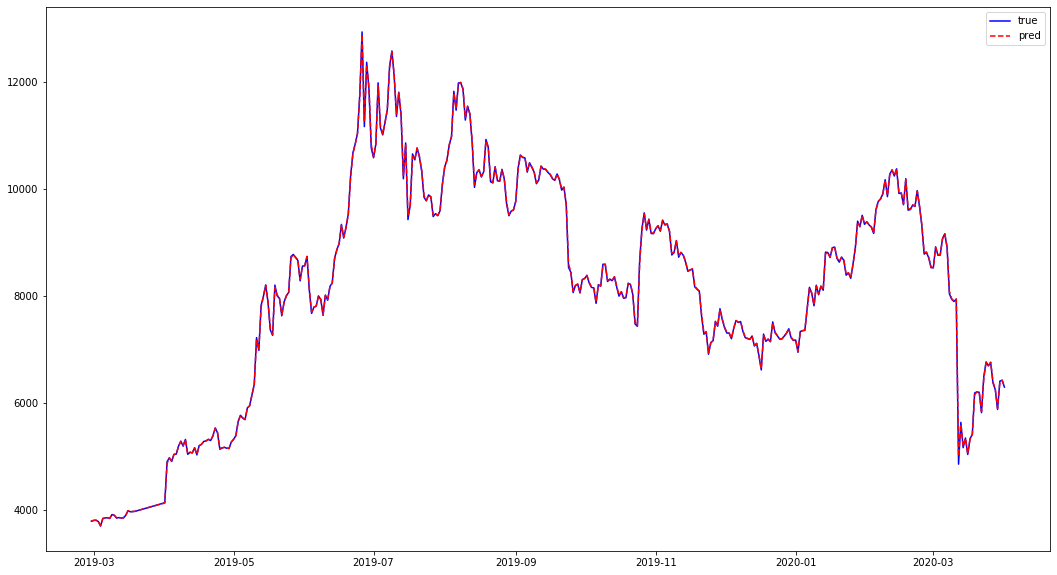

In [11]:
### MAIN

# df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])

days = 1
list_alpha = [a/100 for a in range(0, 100, 5)]
list_beta = [b/100 for b in range(0, 100, 5)]
exponential_smoothing = ExponentialSmoothing(df = df,
                                             percentage_train_size = 0.80, 
                                             list_alpha = list_alpha, 
                                             list_beta = list_beta
                                            )
_ = exponential_smoothing.perform()

In [49]:
#diario
# variando 1 ticket 
# mae 4.8521 mape 0.0597 mse 35.0715 rmse 5.9221 rmspe 0.0747 r2 1.0 pears
# AIC 17276.259290836486 best_params (0.99, 0.0)
# 80% treino

#diario
# variando 5 ticket
# mae 12.4462 mape 0.1511 mse 369.8041 rmse 19.2303 rmspe 0.2581 r2 0.9999 pearson 1.0
# AIC 17288.249021280662 best_params (0.95, 0.0)
# 80% treino

#por hora 
#variando 5 ticket
#mae 1.7675 mape 0.023 mse 10.7606 rmse 3.2803 rmspe 0.0485 r2 1.0 pearson 1.0
#AIC 174734.91212908336 best_params (0.95, 0.0)
#80% treino

In [26]:
class ARIMAForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['Close'].values)
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
        
#         mod = sm.tsa.statespace.SARIMAX(self.df[:last_index],
#                                         order=(best_order[0], best_order[1], best_order[2]),
#                                         seasonal_order=(0, 0, 0, 0),
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()
#         pred = results.forecast(steps = 1)
        
        model = pm.ARIMA(order = best_order) #enforce_stationarity = False
        model = model.fit(self.df[:last_index])
        
#         model = model.update(self.df[last_index:last_index])
        
        print(self.df[last_index:last_index])
        pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        pq_rng = range(5) # [0,1,2,3]
        d_rng = range(3) # [0,1]
        for p in pq_rng:
            for d in d_rng:
                for q in pq_rng:
                    try:
                        mod = pm.ARIMA(order=(p, d, q))

                        results = mod.fit(self.df.iloc[:last_index])

                        tmp_aic = results.aic()
                        
                        if tmp_aic < best_aic:
                            best_aic = tmp_aic
                            best_order = (p, d, q)
                            best_mdl = mod #não esta sendo utilizado
                            
                    except: continue
        
#         model = pm.auto_arima(self.df.iloc[:-last_index],
#                               start_p = 0,
#                               start_q = 0, 
#                               start_d = 0, 
#                               max_p = 5,
#                               max_d = 2,
#                               max_q = 5,
#                               seasonal=False)

#         best_aic = model.aic()
#         best_order = model.order #não esta sendo utilizado
#         best_mdl = model
        
        
        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index, best_mdl
    




aic: 199.86 | order: (0, 1, 2)
             Close
Date              
2020-02-24  9660.0
last_index 2020-02-24 00:00:00
pred 9653.033223662658
             Close
Date              
2020-02-25  9305.0
last_index 2020-02-25 00:00:00
pred 9306.71680036438
             Close
Date              
2020-02-26  8778.3
last_index 2020-02-26 00:00:00
pred 8774.91592258863
              Close
Date               
2020-02-27  8812.49
last_index 2020-02-27 00:00:00
pred 8825.871280507403
              Close
Date               
2020-02-28  8708.89
last_index 2020-02-28 00:00:00
pred 8709.807792770505
              Close
Date               
2020-02-29  8525.07
last_index 2020-02-29 00:00:00
pred 8526.487823567797
              Close
Date               
2020-03-01  8522.31
last_index 2020-03-01 00:00:00
pred 8529.195796732265
             Close
Date              
2020-03-02  8915.0
last_index 2020-03-02 00:00:00
pred 8929.042807201531
              Close
Date               
2020-03-03  8757.84
last_index 

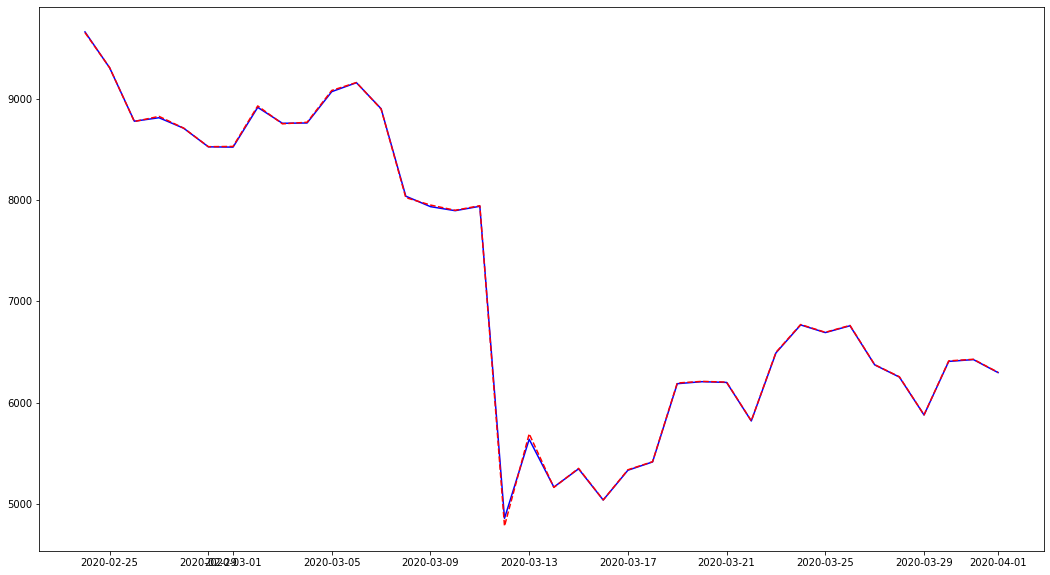

In [27]:
### MAIN

# df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])


arima_forecast = ARIMAForecast(df = df, 
                               percentage_train_size = 0.98)
arima_forecast.perform()

In [22]:
# diario
# aic: 21644.13 | order: (1, 1, 1)
# mae 20.9351 mape 0.2591 mse 877.1319 rmse 29.6164 rmspe 0.3744 r2 0.9998 pearson 0.9999
# 80% treino (numero de previssoes: 387) 
# depois de colocar update
# mae 22.3735 mape 0.2792 mse 1009.2598 rmse 31.7688 rmspe 0.406 r2 0.9998 pearson 0.9999

# por hora
# aic: 229438.22 | order: (2, 1, 2)
# mae 2.5702 mape 0.0333 mse 21.1397 rmse 4.5978 rmspe 0.0663 r2 1.0 pearson 1.0
# 80% treino (numero de previssoes: 4824) 

In [ ]:
class ProphetForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        self.df.columns = ['ds', 'y']
        print('self.df head', self.df.tail())
        best_order, last_index = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
    
            pred = self.prediction(best_order = best_order, last_index = row[1])
            array_pred = np.append(array_pred, pred)
            print('last_index', row[1])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['y'].values)
        
        y_true = self.df.iloc[-last_index:]['y'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        mape = self.mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred)
        print('mape', mape)
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        plot.legend()
        
    def mean_absolute_percentage_error(self, y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    def prediction(self, best_order, last_index):
        
        model = Prophet(daily_seasonality=True)
        model.fit(self.df[ self.df['ds'] <= last_index])
        future = model.make_future_dataframe(periods=1, freq='D')
        print('head\n', self.df[ self.df['ds'] <= last_index].tail(1))
        print('future\n', future.tail(1))
        forecast = model.predict(future)
        print('forecast\n', forecast.iloc[-1][['ds', 'yhat']])
        print('yhat\n', forecast.iloc[-1]['yhat'])
        return forecast.iloc[-1]['yhat']
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None
        #otimizar treino não implementado
        #yearly_seasonality = False, daily_seasonality = False, weekly_seasonality = False    
        m = Prophet()
        m.fit(self.df[:-last_index])

            
#             tmp_aic = results.aic
#             if tmp_aic < best_aic:
#                 best_aic = tmp_aic
#                 best_order = (i, d, j)
#                 best_mdl = mod #não esta sendo utilizado

#         print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return None, last_index
    




In [ ]:
### MAIN

#df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

#df = df.set_index('Date')
df = df[['Date', 'Close']]
df = df.sort_values(by = ['Date']).reset_index(drop = True)


prophet_forecast = ProphetForecast(df = df, 
                                    percentage_train_size = 0.98)
prophet_forecast.perform()

#### Não deu certo

In [125]:
class ARForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
        
#         mod = sm.tsa.statespace.SARIMAX(self.df[:last_index],
#                                         order=(best_order[0], best_order[1], best_order[2]),
#                                         seasonal_order=(0, 0, 0, 0),
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()
#         pred = results.forecast(steps = 1)
        
        model = pm.ARIMA(order = best_order) #enforce_stationarity = False
        model = model.fit(self.df[:last_index])
        
#         model = model.update(self.df[last_index:last_index])
        
        print(self.df[last_index:last_index])
        pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        p_rng = range(6)
        d_rng = range(3) # [0,1,2]
        for d in d_rng:
            for p in p_rng:
                try:
                    mod = pm.ARIMA(order=(p, d, 0))

                    results = mod.fit(self.df.iloc[:last_index])

                    tmp_aic = results.aic()
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, d, 0)
                        best_mdl = mod #não esta sendo utilizado
                except: continue
        
#         model = pm.auto_arima(self.df.iloc[:-last_index],
#                               start_p = 0,
#                               start_q = 0, 
#                               start_d = 0, 
#                               max_p = 5,
#                               max_d = 2,
#                               max_q = 0,
#                               seasonal=False)

#         best_aic = model.aic()
#         best_order = model.order #não esta sendo utilizado
#         best_mdl = model
        
        
        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index, best_mdl
    




aic: 3033.27 | order: (4, 1, 0)
              Close
Date               
2019-02-28  3792.14
last_index 2019-02-28 00:00:00
pred 3790.3956972479177
              Close
Date               
2019-03-01  3806.17
last_index 2019-03-01 00:00:00
pred 3810.316152109648
             Close
Date              
2019-03-02  3809.7
last_index 2019-03-02 00:00:00
pred 3811.7326178448916
              Close
Date               
2019-03-03  3786.93
last_index 2019-03-03 00:00:00
pred 3787.780866322245
              Close
Date               
2019-03-04  3700.72
last_index 2019-03-04 00:00:00
pred 3696.884506089793
              Close
Date               
2019-03-05  3844.59
last_index 2019-03-05 00:00:00
pred 3858.9301883048797
              Close
Date               
2019-03-06  3851.89
last_index 2019-03-06 00:00:00
pred 3851.409398426557
              Close
Date               
2019-03-07  3857.05
last_index 2019-03-07 00:00:00
pred 3863.2946384798265
              Close
Date               
2019-03-08  384

             Close
Date              
2019-05-24  8001.7
last_index 2019-05-24 00:00:00
pred 8011.5360756454775
              Close
Date               
2019-05-25  8063.81
last_index 2019-05-25 00:00:00
pred 8078.642166182026
              Close
Date               
2019-05-26  8731.72
last_index 2019-05-26 00:00:00
pred 8771.610258106757
              Close
Date               
2019-05-27  8772.29
last_index 2019-05-27 00:00:00
pred 8762.742712912472
              Close
Date               
2019-05-28  8715.36
last_index 2019-05-28 00:00:00
pred 8712.356737091512
              Close
Date               
2019-05-29  8662.44
last_index 2019-05-29 00:00:00
pred 8644.111084189923
              Close
Date               
2019-05-30  8279.69
last_index 2019-05-30 00:00:00
pred 8258.89711305204
              Close
Date               
2019-05-31  8554.06
last_index 2019-05-31 00:00:00
pred 8586.85767511951
              Close
Date               
2019-06-01  8558.95
last_index 2019-06-01 00:00:00
p

               Close
Date                
2019-08-04  10977.51
last_index 2019-08-04 00:00:00
pred 10969.872176224633
               Close
Date                
2019-08-05  11819.49
last_index 2019-08-05 00:00:00
pred 11845.925976250497
               Close
Date                
2019-08-06  11465.49
last_index 2019-08-06 00:00:00
pred 11438.279732971278
               Close
Date                
2019-08-07  11975.03
last_index 2019-08-07 00:00:00
pred 12007.10281749916
              Close
Date               
2019-08-08  11981.0
last_index 2019-08-08 00:00:00
pred 11937.840528201814
              Close
Date               
2019-08-09  11856.1
last_index 2019-08-09 00:00:00
pred 11884.790343223642
               Close
Date                
2019-08-10  11280.95
last_index 2019-08-10 00:00:00
pred 11254.328357654234
               Close
Date                
2019-08-11  11540.76
last_index 2019-08-11 00:00:00
pred 11559.594420211984
               Close
Date                
2019-08-12  11389.28


             Close
Date              
2019-10-14  8355.0
last_index 2019-10-14 00:00:00
pred 8374.088273569485
              Close
Date               
2019-10-15  8162.44
last_index 2019-10-15 00:00:00
pred 8158.25974605968
              Close
Date               
2019-10-16  7993.54
last_index 2019-10-16 00:00:00
pred 7998.8500521816695
             Close
Date              
2019-10-17  8076.2
last_index 2019-10-17 00:00:00
pred 8079.908383169307
              Close
Date               
2019-10-18  7954.16
last_index 2019-10-18 00:00:00
pred 7957.07337508375
              Close
Date               
2019-10-19  7965.28
last_index 2019-10-19 00:00:00
pred 7979.55271712971
              Close
Date               
2019-10-20  8236.12
last_index 2019-10-20 00:00:00
pred 8242.784179066914
              Close
Date               
2019-10-21  8209.92
last_index 2019-10-21 00:00:00
pred 8213.175718107797
              Close
Date               
2019-10-22  8024.72
last_index 2019-10-22 00:00:00
pred 

              Close
Date               
2019-12-26  7194.13
last_index 2019-12-26 00:00:00
pred 7205.317394647602
              Close
Date               
2019-12-27  7245.83
last_index 2019-12-27 00:00:00
pred 7252.215961702371
              Close
Date               
2019-12-28  7302.67
last_index 2019-12-28 00:00:00
pred 7309.339049214691
              Close
Date               
2019-12-29  7384.89
last_index 2019-12-29 00:00:00
pred 7390.673044033158
             Close
Date              
2019-12-30  7218.0
last_index 2019-12-30 00:00:00
pred 7214.186587482569
              Close
Date               
2019-12-31  7165.72
last_index 2019-12-31 00:00:00
pred 7170.202261565493
              Close
Date               
2020-01-01  7174.33
last_index 2020-01-01 00:00:00
pred 7174.45414361755
              Close
Date               
2020-01-02  6945.02
last_index 2020-01-02 00:00:00
pred 6946.703060014969
              Close
Date               
2020-01-03  7334.45
last_index 2020-01-03 00:00:00
p

              Close
Date               
2020-03-08  8037.76
last_index 2020-03-08 00:00:00
pred 8015.511724382781
              Close
Date               
2020-03-09  7934.52
last_index 2020-03-09 00:00:00
pred 7944.530237220501
              Close
Date               
2020-03-10  7894.68
last_index 2020-03-10 00:00:00
pred 7898.0277615428195
              Close
Date               
2020-03-11  7938.05
last_index 2020-03-11 00:00:00
pred 7968.29637335925
             Close
Date              
2020-03-12  4857.1
last_index 2020-03-12 00:00:00
pred 4781.387391142829
             Close
Date              
2020-03-13  5637.6
last_index 2020-03-13 00:00:00
pred 5691.433298874507
              Close
Date               
2020-03-14  5165.25
last_index 2020-03-14 00:00:00
pred 5128.245968638362
              Close
Date               
2020-03-15  5345.35
last_index 2020-03-15 00:00:00
pred 5390.4323586117935
              Close
Date               
2020-03-16  5037.61
last_index 2020-03-16 00:00:00
pr

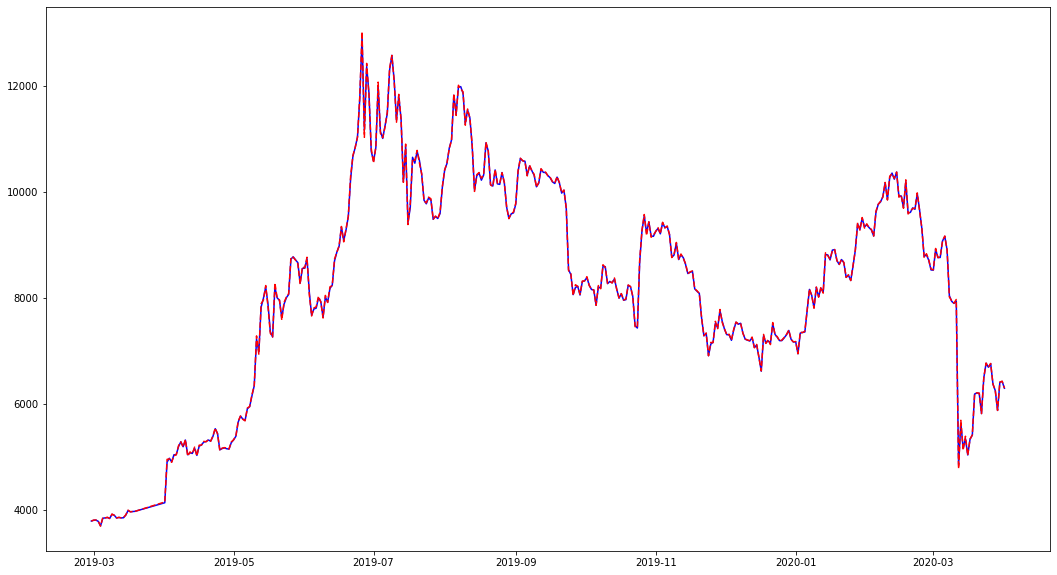

In [126]:
### MAIN

# df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])


ar_forecast = ARForecast(df = df, 
                               percentage_train_size = 0.80)
ar_forecast.perform()

In [21]:
class MAForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
        
#         mod = sm.tsa.statespace.SARIMAX(self.df[:last_index],
#                                         order=(best_order[0], best_order[1], best_order[2]),
#                                         seasonal_order=(0, 0, 0, 0),
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()
#         pred = results.forecast(steps = 1)
        
        model = pm.ARIMA(order = best_order) #enforce_stationarity = False
        model = model.fit(self.df[:last_index])
        
#         model = model.update(self.df[last_index:last_index])
        
        print(self.df[last_index:last_index])
        pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        q_rng = range(6)
        d_rng = range(3) # [0,1,2]
        for d in d_rng:
            for q in q_rng:
                try:
                    mod = pm.ARIMA(order=(0, d, q))

                    results = mod.fit(self.df.iloc[:last_index])

                    tmp_aic = results.aic()
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (0, d, q)
                        best_mdl = mod #não esta sendo utilizado
                except: continue

#         model = pm.auto_arima(self.df.iloc[:-last_index],
#                               start_p = 0,
#                               start_d = 0, 
#                               start_q = 0, 
#                               max_p = 0,
#                               max_d = 2,
#                               max_q = 5,
#                               seasonal=False)

#         best_aic = model.aic()
#         best_order = model.order #não esta sendo utilizado
#         best_mdl = model
        
        
        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index, best_mdl
    




aic: 1568.74 | order: (0, 2, 2)
              Close
Date               
2019-09-22  10026.8
last_index 2019-09-22 00:00:00
pred 10038.901116972986
              Close
Date               
2019-09-23  9693.74
last_index 2019-09-23 00:00:00
pred 9694.709742515694
              Close
Date               
2019-09-24  8530.01
last_index 2019-09-24 00:00:00
pred 8503.160491542238
              Close
Date               
2019-09-25  8438.35
last_index 2019-09-25 00:00:00
pred 8443.582351374402
             Close
Date              
2019-09-26  8060.0
last_index 2019-09-26 00:00:00
pred 8054.742138260657
              Close
Date               
2019-09-27  8193.99
last_index 2019-09-27 00:00:00
pred 8204.690703608943
              Close
Date               
2019-09-28  8217.47
last_index 2019-09-28 00:00:00
pred 8224.463044964114
             Close
Date              
2019-09-29  8052.4
last_index 2019-09-29 00:00:00
pred 8053.520172444063
              Close
Date               
2019-09-30  8304.96
l

              Close
Date               
2019-12-04  7198.99
last_index 2019-12-04 00:00:00
pred 7199.046891870673
              Close
Date               
2019-12-05  7393.54
last_index 2019-12-05 00:00:00
pred 7403.804220084575
              Close
Date               
2019-12-06  7540.08
last_index 2019-12-06 00:00:00
pred 7548.806940473141
              Close
Date               
2019-12-07  7502.19
last_index 2019-12-07 00:00:00
pred 7504.874341607043
             Close
Date              
2019-12-08  7520.0
last_index 2019-12-08 00:00:00
pred 7524.711240387596
              Close
Date               
2019-12-09  7337.51
last_index 2019-12-09 00:00:00
pred 7335.245717870794
              Close
Date               
2019-12-10  7219.37
last_index 2019-12-10 00:00:00
pred 7219.136128367181
              Close
Date               
2019-12-11  7201.23
last_index 2019-12-11 00:00:00
pred 7204.157830326235
              Close
Date               
2019-12-12  7185.91
last_index 2019-12-12 00:00:00


              Close
Date               
2020-02-15  9911.22
last_index 2020-02-15 00:00:00
pred 9907.135388270592
             Close
Date              
2020-02-16  9921.0
last_index 2020-02-16 00:00:00
pred 9930.004808116135
             Close
Date              
2020-02-17  9700.0
last_index 2020-02-17 00:00:00
pred 9701.990397999954
               Close
Date                
2020-02-18  10188.04
last_index 2020-02-18 00:00:00
pred 10209.835203527531
              Close
Date               
2020-02-19  9600.08
last_index 2020-02-19 00:00:00
pred 9593.44700304448
              Close
Date               
2020-02-20  9610.05
last_index 2020-02-20 00:00:00
pred 9618.367256569132
              Close
Date               
2020-02-21  9695.66
last_index 2020-02-21 00:00:00
pred 9705.596034588196
              Close
Date               
2020-02-22  9668.23
last_index 2020-02-22 00:00:00
pred 9675.35182793211
              Close
Date               
2020-02-23  9965.01
last_index 2020-02-23 00:00:00
p

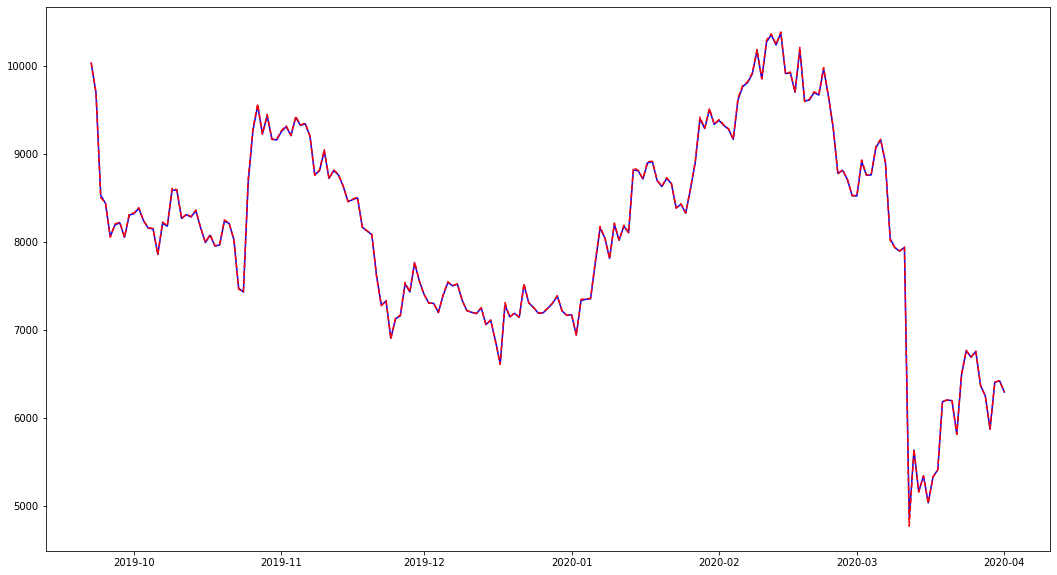

In [22]:
### MAIN

# df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])


ma_forecast = MAForecast(df = df, 
                               percentage_train_size = 0.90)
ma_forecast.perform()

In [46]:
class MSARForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
                
        mod_hamilton = sm.tsa.MarkovAutoregression(self.df[:last_index], k_regimes=2, order=best_order[0], switching_ar=True)
        res_hamilton = mod_hamilton.fit()

        pred = res_hamilton.predict(start = last_index, end = pd.Timestamp(last_index) + pd.Timedelta(days = 1))[-1]
                
        print(self.df[last_index:last_index])
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        p_rng = range(1, 6)
        d_rng = range(1) # [0,1,2]
        
        for d in d_rng:
            for p in p_rng:
                try:
                    mod = sm.tsa.MarkovAutoregression(self.df.iloc[:last_index], k_regimes=2, order=p, switching_ar=True)
                    results = mod_hamilton.fit()

                    tmp_aic = results.aic
                    
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, d)
                        best_mdl = mod #não esta sendo utilizado
                        
                except: continue
        
#         model = pm.auto_arima(self.df.iloc[:-last_index],
#                               start_p = 0,
#                               start_q = 0, 
#                               start_d = 0, 
#                               max_p = 5,
#                               max_d = 2,
#                               max_q = 0,
#                               seasonal=False)

#         best_aic = model.aic()
#         best_order = model.order #não esta sendo utilizado
#         best_mdl = model
        
        
        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index, best_mdl
    




In [47]:
### MAIN

# df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])


msar_forecast = MSARForecast(df = df, 
                             percentage_train_size = 0.90)
msar_forecast.perform()

aic:    inf | order: None


TypeError: 'NoneType' object is not subscriptable

In [32]:
### TREINAR O MSAR E COLOCAR NA CLASSE
# TREINAR USANDO O AIC PARA 2 REGIMES E VARIANDO A ORDEM

In [58]:
# df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])

best_aic = np.inf 
best_order = None
best_mdl = None

p_rng = range(1, 10)
d_rng = range(1) # [0,1,2]

for d in d_rng:
    for p in p_rng:
        print('p', p, 'd', d)
        try:
            mod_hamilton = sm.tsa.MarkovAutoregression(df.iloc[:1700], k_regimes = 2, order = p, switching_ar = True)
            res_hamilton = mod_hamilton.fit()

            tmp_aic = res_hamilton.aic
            print('tmp_aic', tmp_aic)
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (p, d)
                best_mdl = mod_hamilton #não esta sendo utilizado

        except: continue
        
print('aic: %6.2f | order: %s'%(best_aic, best_order))

p 1 d 0
tmp_aic nan
p 2 d 0
tmp_aic nan
p 3 d 0
p 4 d 0
p 5 d 0
p 6 d 0
p 7 d 0
p 8 d 0
p 9 d 0
aic:    inf | order: None


In [33]:
# df.diff().head()
print(df.shape[0])
print(df.diff().dropna(0).shape[0])
# df.diff().fillna(0) + df.iloc[0]['Close'] # primeira derivada
df.diff().diff().fillna(0) + df.diff().fillna(0) + df.iloc[0]['Close'] # segunda derivada

1937
1936


,Close
Date,
2014-12-01,370.00
2014-12-02,378.00
2014-12-03,362.00
2014-12-04,368.20
2014-12-05,370.90
...,...
2020-03-28,514.74
2020-03-29,-258.68
2020-03-30,1802.99


In [60]:
### TESTE

# df = df_coinmarket_price_1h.copy()
df = df_coinmarket_price_d.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])

# df_diff = df.diff().diff().fillna(0) + df.diff().fillna(0) + df.iloc[0]['Close']

mod_hamilton = sm.tsa.MarkovAutoregression(df.iloc[:1700], k_regimes=2, order=5, switching_ar=True)
res_hamilton = mod_hamilton.fit()

print('aic', res_hamilton.aic)
print('predict', res_hamilton.predict())
res_hamilton.summary()

LinAlgError: SVD did not converge

In [11]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    Close   No. Observations:                 1933
Model:             MarkovAutoregression   Log Likelihood              -13647.911
Date:                  Fri, 08 May 2020   AIC                          27321.823
Time:                          19:36:17   BIC                          27394.191
Sample:                               0   HQIC                         27348.441
                                 - 1933                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5663.3222   3164.976      1.789      0.074    -539.916    1.19e+04
ar.L1         -0.1615      0.087     -1.850      0.064      -0.333       0.010
ar.L2          0.2160        nan        nan        nan         nan         nan
ar.L3         -0.0986      3.898     -0.025      0.980      -7.739       7.542
ar.L4         -0.1591      3.410     -0.047      0.963      -6.843       6.524
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4095.1443   3142.944      1.303      0.193   -2064.914    1.03e+04
ar.L1          1.0294      0.023     45.088      0.000       0.985       1.074
ar.L2         -0.0726      0.034     -2.158      0.031      -0.139      -0.007
ar.L3          0.0426      0.032      1.324      0.186      -0.020       0.106
ar.L4         -0.0018      0.021     -0.085      0.932      -0.044       0.040
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.883e+04   2558.252     30.815      0.000    7.38e+04    8.38e+04
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.4991      0.353      1.413      0.158      -0.193       1.191
p[1->0]        0.0005      0.001      1.000      0.317      -0.000       0.002
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

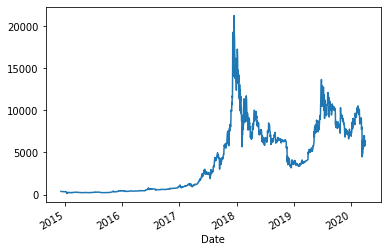

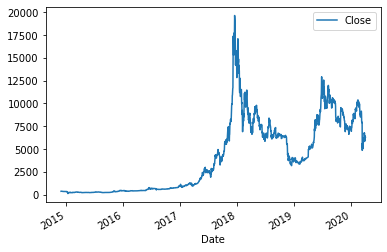

In [37]:
df_graph = df.iloc[1:]['Close'] + res_hamilton.predict()
df_graph.plot()
df.plot()

In [127]:
# threshold autoregressive (TAR) e Markov-switching autoregressive (MSAR)

In [12]:
#fazer uma tabela com resultados 